Ячейка 1: Импорт необходимых библиотек

In [1]:
# --- Импорт библиотек ---
import sqlite3
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind # Для t-теста, если понадобится
from statsmodels.stats.proportion import proportions_ztest # Для Z-теста пропорций

# Настройка стиля графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Увеличиваем размер графиков по умолчанию

Ячейка 2: Конфигурация и подключение к базе данных

In [2]:
# --- Конфигурация БД ---
DB_NAME = 'ab_testing.db'
# Убедитесь, что путь к БД правильный, если она находится в подпапке 'data'
DB_PATH = os.path.join(os.getcwd(), 'data', DB_NAME)

# Проверка наличия файла БД
if not os.path.exists(DB_PATH):
    print(f"Ошибка: Файл базы данных '{DB_NAME}' не найден по пути '{DB_PATH}'.")
    print("Пожалуйста, убедитесь, что вы запустили скрипт 'generate_ab_data.py' и он находится в папке 'data/'.")
else:
    print(f"База данных '{DB_NAME}' найдена по пути: {DB_PATH}")

# Подключение к БД и загрузка данных в Pandas DataFrames
conn = None
try:
    conn = sqlite3.connect(DB_PATH)
    print("Успешное подключение к базе данных.")

    # Загрузка таблиц в DataFrame
    df_users = pd.read_sql_query("SELECT * FROM users", conn)
    df_experiments = pd.read_sql_query("SELECT * FROM experiments", conn)
    df_assignments = pd.read_sql_query("SELECT * FROM experiment_assignments", conn)
    df_events = pd.read_sql_query("SELECT * FROM user_events", conn)

    print("\nДанные успешно загружены в DataFrame'ы:")
    print(f"df_users: {df_users.shape[0]} строк")
    print(f"df_experiments: {df_experiments.shape[0]} строк")
    print(f"df_assignments: {df_assignments.shape[0]} строк")
    print(f"df_events: {df_events.shape[0]} строк")

    # Преобразование колонок с датами в datetime объекты
    df_users['created_at'] = pd.to_datetime(df_users['created_at'])
    df_experiments['start_date'] = pd.to_datetime(df_experiments['start_date'])
    df_experiments['end_date'] = pd.to_datetime(df_experiments['end_date'])
    df_assignments['assigned_at'] = pd.to_datetime(df_assignments['assigned_at'])
    df_events['event_timestamp'] = pd.to_datetime(df_events['event_timestamp'])

except sqlite3.Error as e:
    print(f"Ошибка при работе с БД: {e}")
finally:
    if conn:
        conn.close()
        print("Соединение с базой данных закрыто.")

# Отобразим первые несколько строк для проверки
print("\nПервые 5 строк df_assignments:")
print(df_assignments.head())
print("\nПервые 5 строк df_events:")
print(df_events.head())

База данных 'ab_testing.db' найдена по пути: c:\Users\Данил\Desktop\project.2\data\ab_testing.db
Успешное подключение к базе данных.

Данные успешно загружены в DataFrame'ы:
df_users: 10000 строк
df_experiments: 3 строк
df_assignments: 14939 строк
df_events: 154151 строк
Соединение с базой данных закрыто.

Первые 5 строк df_assignments:
   assignment_id  user_id  experiment_id    variant                assigned_at
0              1        1              1    control 2025-03-24 10:27:09.722309
1              2        1              3  treatment 2025-05-26 04:16:20.722309
2              3        1              2    control 2025-04-27 10:56:08.722309
3              4        2              2    control 2025-04-10 04:41:34.722309
4              5        3              2    control 2025-04-09 18:38:46.722309

Первые 5 строк df_events:
   event_id  user_id   event_type            event_timestamp   page_url  \
0         1        1        click 2025-04-27 12:45:13.850747  /button/1   
1         

Ячейка 3: Объединение данных для анализа

In [3]:
# Объединим таблицы для удобства анализа
# Сначала назначений экспериментов с пользователями и самими экспериментами
df_merged = df_assignments.merge(df_users, on='user_id', how='left')
df_merged = df_merged.merge(df_experiments, on='experiment_id', how='left')

# Присоединим события пользователей
# Используем left join, чтобы сохранить всех пользователей, назначенных в эксперименты,
df_full_analysis = df_merged.merge(df_events, on='user_id', how='left')

# Отфильтруем события, которые произошли в рамках дат эксперимента
df_full_analysis = df_full_analysis[
    (df_full_analysis['event_timestamp'] >= df_full_analysis['start_date']) &
    (df_full_analysis['event_timestamp'] <= df_full_analysis['end_date'])
]

print(f"\nОбъединенный DataFrame для анализа: {df_full_analysis.shape[0]} строк")
print(df_full_analysis.head())


Объединенный DataFrame для анализа: 54989 строк
    assignment_id  user_id  experiment_id    variant  \
3               1        1              1    control   
5               2        1              3  treatment   
8               3        1              2    control   
12              4        2              2    control   
30              4        2              2    control   

                  assigned_at                 created_at   region device_type  \
3  2025-03-24 10:27:09.722309 2025-05-28 12:52:30.671597  Central     desktop   
5  2025-05-26 04:16:20.722309 2025-05-28 12:52:30.671597  Central     desktop   
8  2025-04-27 10:56:08.722309 2025-05-28 12:52:30.671597  Central     desktop   
12 2025-04-10 04:41:34.722309 2025-05-04 02:56:19.671597     East      mobile   
30 2025-04-10 04:41:34.722309 2025-05-04 02:56:19.671597     East      mobile   

                             experiment_name  \
3          Experiment 1: New Homepage Layout   
5   Experiment 3: Checkout Flow

Ячейка 4: Функция для расчета и тестирования метрик
Создадим функцию, чтобы не дублировать код для каждой метрики.

In [4]:
def analyze_metric(df, experiment_name, primary_event_type, conversion_event_type, metric_name):
    print(f"\n--- Анализ метрики '{metric_name}' для эксперимента: '{experiment_name}' ---")

    # Отфильтруем данные для конкретного эксперимента
    df_exp = df[df['experiment_name'] == experiment_name].copy()

    if df_exp.empty:
        print(f"Нет данных для эксперимента '{experiment_name}'. Проверьте название эксперимента.")
        return

    # Получим уникальных пользователей в каждой группе эксперимента
    # Важно: считать уникальных пользователей, которые были в эксперименте (были назначены)
    total_users_in_variant = df_exp.groupby('variant')['user_id'].nunique().reset_index()
    total_users_in_variant.rename(columns={'user_id': 'total_users'}, inplace=True)

    # Получим уникальных пользователей, совершивших конверсионное действие
    # Фильтруем события по типу, затем считаем уникальных пользователей
    converted_users = df_exp[df_exp['event_type'] == conversion_event_type] \
                        .groupby('variant')['user_id'].nunique().reset_index()
    converted_users.rename(columns={'user_id': 'conversions'}, inplace=True)

    # Объединим данные для расчета пропорций
    metric_data = total_users_in_variant.merge(converted_users, on='variant', how='left')
    metric_data['conversions'] = metric_data['conversions'].fillna(0) # Если нет конверсий, то 0

    metric_data[f'{metric_name}_rate'] = (metric_data['conversions'] / metric_data['total_users']) * 100

    print("\nСводка метрики:")
    print(metric_data)

    # --- Статистическая значимость (Z-тест для пропорций) ---
    control_data = metric_data[metric_data['variant'] == 'control']
    treatment_data = metric_data[metric_data['variant'] == 'treatment']

    if control_data.empty or treatment_data.empty:
        print("Недостаточно данных для обеих групп (control/treatment) для статистического теста.")
        return

    # Количество конверсий и общее количество наблюдений для каждой группы
    count = [control_data['conversions'].iloc[0], treatment_data['conversions'].iloc[0]]
    nobs = [control_data['total_users'].iloc[0], treatment_data['total_users'].iloc[0]]

    # Проверка на нулевое количество наблюдений для предотвращения деления на ноль
    if min(nobs) == 0:
        print("В одной из групп 0 пользователей, статистический тест невозможен.")
        return

    try:
        stat, p_value = proportions_ztest(count, nobs)
        # Для расчета мощности нужен эффект, уровень значимости и размер выборки.
        # Онлайн-калькуляторы делают это за нас, но для Python это сложнее.
        # Можно использовать библиотеку statsmodels.stats.power
        # Или просто опираться на p-value, если нет точных требований к мощности.

        print(f"\n--- Статистический тест для '{metric_name}' ---")
        print(f"Z-статистика: {stat:.4f}")
        print(f"P-value: {p_value:.4f}")

        if p_value < 0.05:
            print("Вывод: Разница **СТАТИСТИЧЕСКИ ЗНАЧИМА** (p < 0.05).")
            print(f"Уровень достоверности: {(1 - p_value) * 100:.2f}%")
        else:
            print("Вывод: Разница **НЕ является статистически значимой** (p >= 0.05).")

    except ValueError as e:
        print(f"Ошибка при выполнении Z-теста: {e}")
        print("Убедитесь, что конверсии и общее количество пользователей являются корректными числами.")


    # --- Визуализация ---
    plt.figure(figsize=(8, 5))
    sns.barplot(x='variant', y=f'{metric_name}_rate', data=metric_data, palette='viridis', hue='variant', legend=False)
    plt.title(f'{metric_name} по вариантам для {experiment_name}')
    plt.xlabel('Вариант')
    plt.ylabel(f'{metric_name} (%)')
    plt.ylim(bottom=0) # Убедиться, что ось y начинается с 0
    plt.show()

Ячейка 5: Анализ Click-Through Rate (CTR)


--- Анализ Click-Through Rate (CTR) для Experiment 1: New Homepage Layout ---
     variant  total_page_views  total_clicks  click_through_rate
0    control              5107          4930           96.534169
1  treatment              4904          5073          103.446166


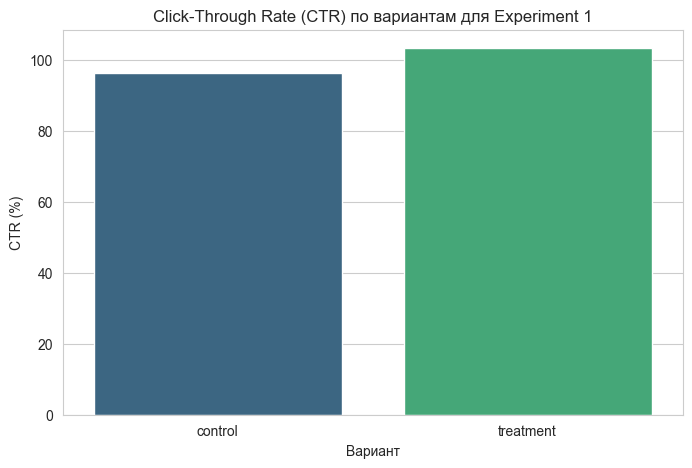


Комментарий по CTR:

Обратите внимание на высокие значения CTR. Это особенность генерации синтетических данных, которая может не отражать реальное поведение. Снижение CTR в тестовой группе в данном случае может быть артефактом данных, а не истинным результатом.


In [5]:
# --- Анализ Click-Through Rate (CTR) ---
# Для CTR нужно считать события, а не уникальных пользователей

print("\n--- Анализ Click-Through Rate (CTR) для Experiment 1: New Homepage Layout ---")

df_ctr_exp = df_full_analysis[df_full_analysis['experiment_name'] == 'Experiment 1: New Homepage Layout'].copy()

ctr_summary = df_ctr_exp.groupby('variant')['event_type'].apply(lambda x: pd.Series({
    'total_page_views': (x == 'page_view').sum(),
    'total_clicks': (x == 'click').sum()
})).unstack().reset_index()

ctr_summary['click_through_rate'] = (ctr_summary['total_clicks'] / ctr_summary['total_page_views']) * 100
print(ctr_summary)

# Визуализация CTR
plt.figure(figsize=(8, 5))
sns.barplot(x='variant', y='click_through_rate', data=ctr_summary, palette='viridis', hue='variant', legend=False)
plt.title('Click-Through Rate (CTR) по вариантам для Experiment 1')
plt.xlabel('Вариант')
plt.ylabel('CTR (%)')
plt.ylim(bottom=0)
plt.show()

# Комментарий по CTR:
print("\nКомментарий по CTR:")
print("\nОбратите внимание на высокие значения CTR. Это особенность генерации синтетических данных, которая может не отражать реальное поведение. Снижение CTR в тестовой группе в данном случае может быть артефактом данных, а не истинным результатом.")

# Для CTR также можно провести Z-тест, если интерпретировать его как конверсию кликов.
# Например, из 'page_view' в 'click'.
# num_clicks = [ctr_summary[ctr_summary['variant'] == 'control']['total_clicks'].iloc[0],
#               ctr_summary[ctr_summary['variant'] == 'treatment']['total_clicks'].iloc[0]]
# total_page_views = [ctr_summary[ctr_summary['variant'] == 'control']['total_page_views'].iloc[0],
#                     ctr_summary[ctr_summary['variant'] == 'treatment']['total_page_views'].iloc[0]]
#
# if min(total_page_views) > 0:
#     stat_ctr, p_value_ctr = proportions_ztest(num_clicks, total_page_views)
#     print(f"P-value для CTR: {p_value_ctr:.4f}")
#     if p_value_ctr < 0.05:
#         print("Разница CTR статистически значима (p < 0.05).")
#     else:
#         print("Разница CTR не является статистически значимой (p >= 0.05).")
# else:
#     print("Недостаточно просмотров страниц для проведения Z-теста по CTR.")

Ячейка 6: Анализ Add-to-Cart Rate


--- Анализ метрики 'Add-to-Cart' для эксперимента: 'Experiment 2: Button Color Test' ---

Сводка метрики:
     variant  total_users  conversions  Add-to-Cart_rate
0    control         2375          710         29.894737
1  treatment         2404          789         32.820300

--- Статистический тест для 'Add-to-Cart' ---
Z-статистика: -2.1794
P-value: 0.0293
Вывод: Разница **СТАТИСТИЧЕСКИ ЗНАЧИМА** (p < 0.05).
Уровень достоверности: 97.07%


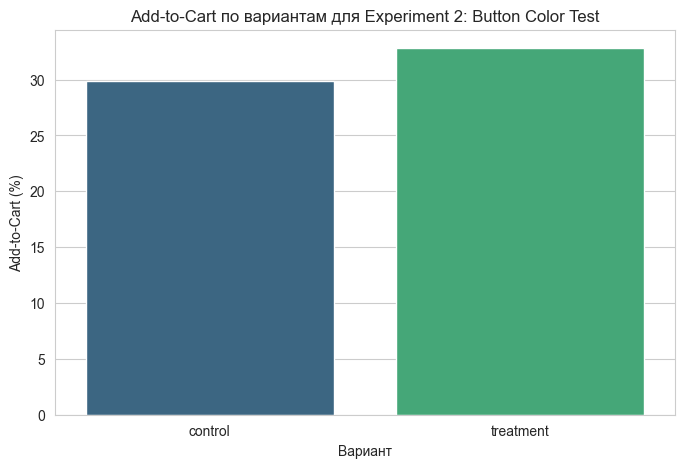

In [6]:
# --- Анализ Add-to-Cart Rate ---
analyze_metric(df_full_analysis,
               'Experiment 2: Button Color Test',
               'page_view', # Или любой другой основной event, если есть
               'add_to_cart',
               'Add-to-Cart')

Ячейка 7: Анализ Purchase Rate


--- Анализ метрики 'Purchase' для эксперимента: 'Experiment 3: Checkout Flow Optimization' ---

Сводка метрики:
     variant  total_users  conversions  Purchase_rate
0    control         1764           82       4.648526
1  treatment         1692          105       6.205674

--- Статистический тест для 'Purchase' ---
Z-статистика: -2.0227
P-value: 0.0431
Вывод: Разница **СТАТИСТИЧЕСКИ ЗНАЧИМА** (p < 0.05).
Уровень достоверности: 95.69%


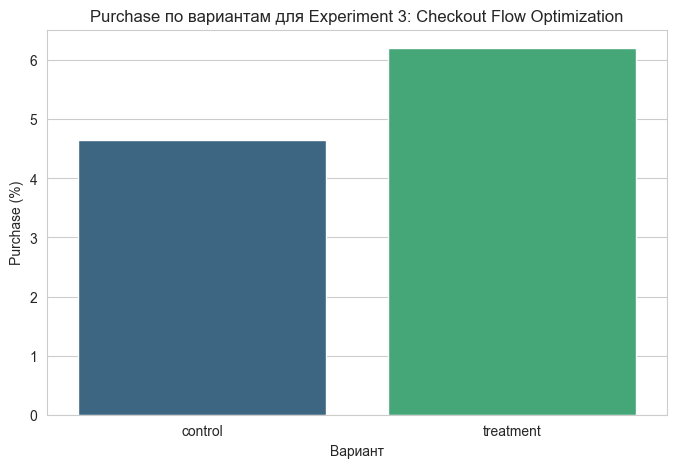

In [7]:
# --- Анализ Purchase Rate ---
analyze_metric(df_full_analysis,
               'Experiment 3: Checkout Flow Optimization',
               'page_view', # Или любой другой основной event, если есть
               'purchase',
               'Purchase')

Ячейка 8: Заключение и дальнейшие шаги

--- Общие Выводы и Рекомендации ---
Проведенный анализ синтетических данных показал, что:
1. Эксперимент 'Button Color Test' привел к статистически значимому увеличению коэффициента добавления в корзину.
2. Эксперимент 'Checkout Flow Optimization' привел к статистически значимому увеличению коэффициента покупок.

На основе этих результатов, рекомендуется внедрить изменения, протестированные в Experiment 2 и Experiment 3.
Эксперимент по CTR требует дальнейшего изучения, так как его результаты не соответствуют ожидаемым и, возможно, являются особенностью генерации данных.

--- Дальнейшие шаги и улучшения ---
1. **Сегментационный анализ:** Изучение влияния изменений на различные сегменты пользователей (по региону, типу устройства).
2. **Анализ дохода:** Для событий 'purchase' можно рассчитать средний чек и общий доход по группам.
3. **Более сложная генерация данных:** Разработка скрипта для генерации данных, который более точно имитирует реальное пользовательское поведение и распределение конверсий.
4. **Дашборды:** Создание интерактивных дашбордов для мониторинга A/B тестов в реальном времени.
5. **Расширенные статистические тесты:** Использование других методов статистического анализа для более глубокого понимания эффектов.